In [1]:
import setup_notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

from grandexchange.preprocess import load_preprocessed_data

# How many steps in the future to predict
N_PREDICT_STEPS = 7

# Number of steps for the first cross validation fold
MIN_CV_SIZE = 500

### Load data

In [2]:
data = load_preprocessed_data(6)

# For now take a sample of 5 items to test model
data = data[
    data["item_id"].isin(
        data["item_id"].sample(5, random_state=42)
    )
]

Local DB found, checking for updated grandexchange...
No new data found


### Cross-validation

Logic:
- Forward rolling cross validation with MIN_CV_SIZE as the first fold
- This initial training set will be the first fold and  will predict the next N_PREDICT_STEPS (test set) and store:
    1. The predicted and actual
    1. The number of days ahead the prediction was for
- The new training set will be the previous fold plus the previous test set

In [3]:
steps = data.datetime.unique()
cv_folds = {}

fold = 0

train_size = MIN_CV_SIZE
train_fold = steps[:train_size]
test_fold = steps[train_size:(train_size + N_PREDICT_STEPS)]

while train_size + N_PREDICT_STEPS <= len(steps):
    cv_folds[fold] = {
        "train": train_fold,
        "test": test_fold
    }
    fold += 1
    train_size += N_PREDICT_STEPS

### Baseline model

Predict the next days as the average of the previous 7 days

In [22]:
def run_baseline_model():
    fold_results = []

    for fold in cv_folds.keys():
        train = data[data["datetime"].isin(cv_folds[fold]["train"][-7:])]
        test = data[data["datetime"].isin(cv_folds[fold]["test"])]
        pred = train.groupby("item_id")["price"].mean().reset_index()

        preds = pd.concat([
            pred.assign(fold=x) for x in cv_folds.keys()
        ], axis=0).rename({"price": "predicted"}, axis=1)

    # Add all test datetimes
    cv_results = pd.merge(
        preds,
        test[["item_id", "datetime"]],
        on=["item_id"]
    )
    # Add actual price to each datetime and item_id
    cv_results = pd.merge(
        cv_results,
        test[["item_id", "price", "datetime"]].rename({"price": "actual"}, axis=1),
        on=["item_id", "datetime"]
    )
    # Add step
    cv_results = cv_results.merge(
        (
            cv_results[["datetime"]]
            .drop_duplicates()
            .reset_index(drop=True)
            .reset_index()
        ).rename({"index": "step"}, axis=1),
        on="datetime"
    )
    # cv_results["mape"] = mean_absolute_percentage_error(cv_results["actual"], cv_results["predicted"])
    cv_eval = cv_results.groupby(["step"]).apply(lambda x: mean_absolute_percentage_error(x["actual"], x["predicted"]))
    return cv_results.reset_index(drop=True), cv_eval.reset_index(name="MAPE")

baseline_results = run_baseline_model()

<AxesSubplot:xlabel='step', ylabel='MAPE'>

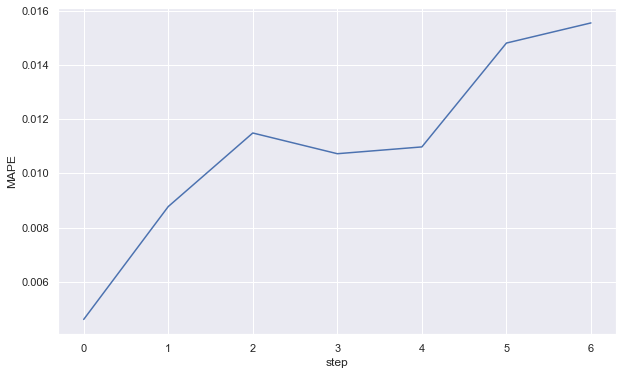

In [27]:
sns.set(rc = {'figure.figsize':(10, 6)})
sns.lineplot(data=baseline_results[1], x="step", y="MAPE")

### FBProphet

Univariate time-series prediction

### DeepAR

Multivariate deep learning algorithm

### XGBoost

Direct multistep multivariate prediction using XGBoost